In [3]:
import os
import json
import torch
import numpy as np
import pandas as pd
from cv2 import equalizeHist
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder

In [2]:
with open('content\VsegDATA\label.json', 'r', encoding='utf-8') as f:
    labels = json.load(f)

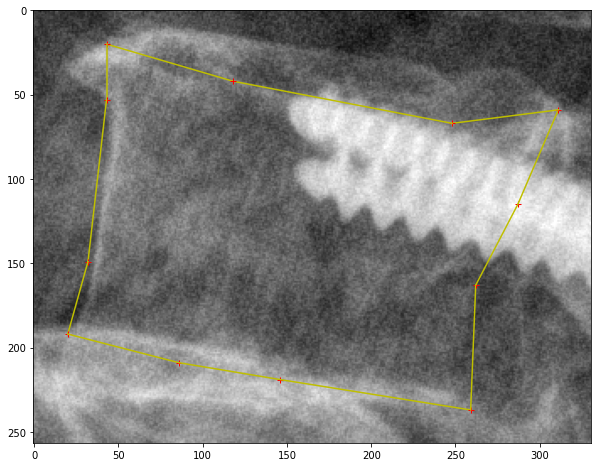

In [3]:
fn = '01990231_FILE1_L4.bmp'
ft = 'unsure'

l = labels[ft][fn]

img = Image.open(os.path.join('content\VsegDATA', ft, fn))
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

for idx, (x, y) in enumerate(zip(l['xs'], l['ys'])):

    if idx != 0:
        plt.plot([x, x2], [y, y2], 'y-')
    else:
        plt.plot([x, l['xs'][-1]], [y, l['ys'][-1]], 'y-')

    plt.plot(x, y, 'r+')

    x2, y2 = x, y

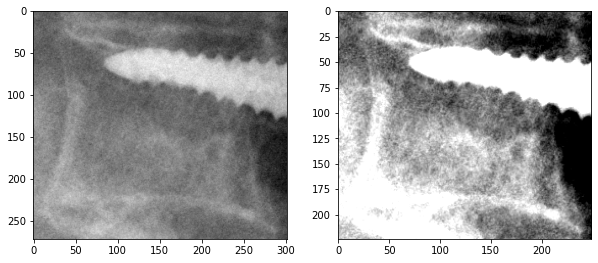

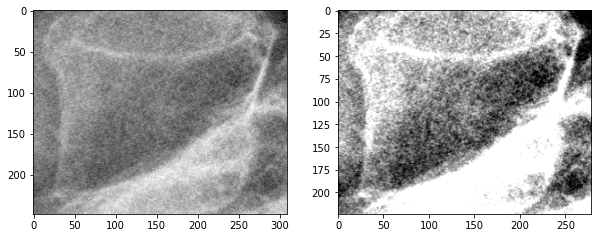

In [4]:
s = nn.Sequential(
    transforms.Resize(224),
    # transforms.CenterCrop(224),
)


fn = '05609172_FILE0_L1.bmp'
ft = 'unsure'

img = Image.open(os.path.join('content\VsegDATA', ft, fn))

img2 = s(img)
img2 = TF.adjust_contrast(img2, 7)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(img2, cmap='gray')

fn = '00048035_FILE4_L5.bmp'
ft = 'normal'

img = Image.open(os.path.join('content\VsegDATA', ft, fn))

img2 = s(img)
img2 = TF.adjust_contrast(img2, 7)
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(img, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(img2, cmap='gray')


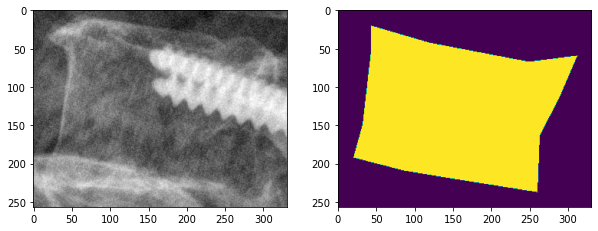

In [5]:
fd = '01990231_FILE1_L4'
ft = 'unsure'

plt.figure(figsize=(10,10))

img_fp = os.path.join('content/VsegDATA1/image', ft, fd+'.bmp')
msk_fp = os.path.join('content/VsegDATA1/mask', ft, fd+'.txt')

img = Image.open(img_fp)
mask = np.loadtxt(msk_fp , dtype='long')

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask)

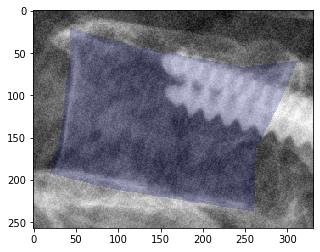

In [6]:
masked = np.ma.masked_where(mask == 0, mask)
plt.imshow(img, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.2)
plt.show()

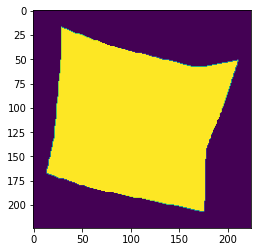

In [7]:
# torchvision transfromation for numpy array
mask = mask.astype(dtype='long')
k = TF.to_pil_image(mask)
k = TF.resize(k, [224, 224])
k = np.asarray(k)
plt.imshow(k)

In [8]:
class VertexDataset(Dataset):

    def __init__(self, filenames, labels, transform):

        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):

        return len(self.filenames)

    def __getitem__(self, idx):

        img = Image.open(self.filenames[idx])
        label = np.loadtxt(self.labels[idx], dtype='long')

        img = self.transform(img)
        label = TF.to_pil_image(label)
        label = TF.resize(label, [224, 224])
        label = np.asarray(label)

        return img, label

In [9]:
batch_size = 1

train_transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

test_transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

def split_Train_Val_Data(data_dir):

    img_fpr = os.path.join('content/VsegDATA1/image')
    msk_fpr = os.path.join('content/VsegDATA1/mask')

    # dataset -> [(image_path, mask_path)]
    dataset = []

    for typev in os.listdir(img_fpr):
        
        img_fps = os.listdir(os.path.join(img_fpr, typev))
        msk_fps = os.listdir(os.path.join(msk_fpr, typev))

        for img_fp, msk_fp in zip(img_fps, msk_fps):

            temp = (
                os.path.join(os.path.join(img_fpr, typev, img_fp)),
                os.path.join(os.path.join(msk_fpr, typev, msk_fp)),
                )

            dataset.append(temp)


    np.random.seed(69)
    np.random.shuffle(dataset)

    mid = int(len(dataset)*0.8)

    train_inputs, train_masks = [], []
    test_inputs, test_masks = [], []

    for data in dataset[:mid]:
        train_inputs.append(data[0])
        train_masks.append(data[1])

    for data in dataset[mid:]:
        test_inputs.append(data[0])
        test_masks.append(data[1])

    train_dataloader = DataLoader(VertexDataset(train_inputs, train_masks, train_transformer), batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(VertexDataset(test_inputs, test_masks, test_transformer), batch_size = batch_size, shuffle = False)

    return train_dataloader, test_dataloader    

In [10]:
train_dataloader, test_dataloader = split_Train_Val_Data('k')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\_utils\collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return default_collate([torch.as_tensor(b) for b in batch])


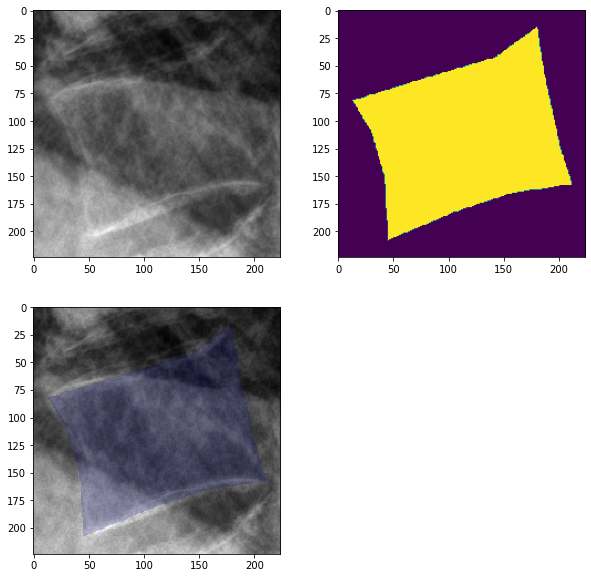

torch.Size([1, 1, 224, 224])
torch.Size([1, 224, 224])


In [11]:
for i,m in train_dataloader:

    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    plt.imshow(i.squeeze(0).squeeze(0), cmap='gray')
    
    plt.subplot(2,2,2)
    plt.imshow(m.squeeze(0))
    
    plt.subplot(2,2,3)
    masked = np.ma.masked_where(m.squeeze(0) == 0, m.squeeze(0))
    plt.imshow(i.squeeze(0).squeeze(0), 'gray', interpolation='none')
    plt.imshow(masked, 'jet', interpolation='none', alpha=0.2)
    plt.show()
    print(i.shape)
    print(m.shape)
    break

In [22]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = TF.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [23]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])


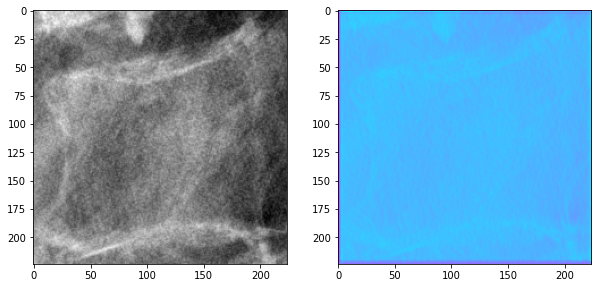

In [45]:
plt.figure(figsize=(10,10))
net = UNet(1,1)
net.eval()
for i,m in train_dataloader:
    print(i.shape)
    plt.subplot(1,2,1)
    plt.imshow(i.squeeze(0).squeeze(0), cmap='gray')
    out = net(i)
    break
print(out.shape)
plt.subplot(1,2,2)
out_msk = torch.detach(out).squeeze(0).squeeze(0)
plt.imshow(out_msk, cmap='cool')

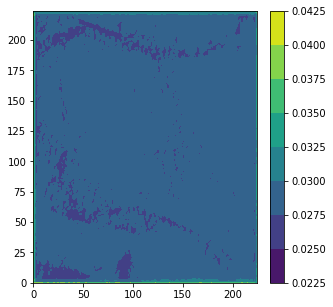

In [92]:
fig= plt.figure(figsize=(5,5))
levels = list(np.arange(0.,1.,0.01))
v = np.linspace(0, 224,224)
x, y = np.meshgrid(v,v)
cf = plt.contourf(x, y, out_msk)
plt.colorbar(cf)

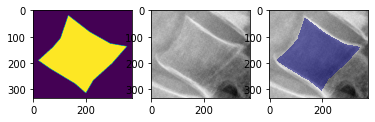

In [2]:
from PIL import Image

m = np.loadtxt('C:\\Users\\user\\OneDrive\\桌面\\vertex\\content\\VsegDATA1\\mask\\normal\\00048035_FILE0_L2.txt')
i = Image.open('C:\\Users\\user\\OneDrive\\桌面\\vertex\\content\\VsegDATA1\\image\\normal\\00048035_FILE0_L2.bmp')

fig, ax = plt.subplots(1, 3)
mk = np.ma.masked_where(m<0.8, m)

ax[0].imshow(m)
ax[1].imshow(i, cmap='gray')
ax[2].imshow(i, cmap='gray')
ax[2].imshow(mk, alpha=0.5, cmap='jet')

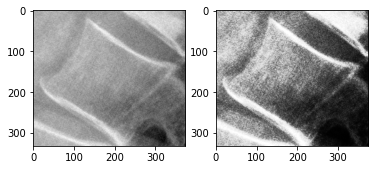

In [4]:
fig, ax = plt.subplots(1,2)
i2 = Image.fromarray(equalizeHist(np.array(i)))

ax[0].imshow(i, cmap='gray')
ax[1].imshow(i2, cmap='gray')